In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectPercentile
import re
import warnings
import time
import gc
import random
warnings.filterwarnings('ignore')

In [3]:
import nltk
# import augly.text as txtaugs
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# nltk.download('punkt_tab')

from nltk.corpus import  stopwords, wordnet

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


In [4]:
!pip install nltk
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
import keras_hub
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Conv1D, Bidirectional
from tensorflow.keras.layers import MaxPooling1D, Flatten, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from keras.regularizers import L1L2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV

### EDA

In [6]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
train.sample(3)

,id,keyword,location,text,target
7118,10198,violent%20storm,"Very SW CA, USA....Draenor",@iateyourfood yikes. Poor pup. What a weird ...,1
6927,9935,trouble,NaN,The trouble in one of Buffett's favorite secto...,0
595,860,bioterror,"Pelham, AL",Thank you @FedEx for no longer shipping live m...,0


In [9]:
# Check for nulls
nulls = train.isnull().sum().loc[lambda x: x >0]
print(f"Number of sentences where some col has null values:\n{nulls}")

# Check duplicates
duplicates = train.duplicated().sum()
print(f"Number of duplicates : {duplicates}")

# Number of unique words
unique_words = len(np.unique(train['text']))
print(f"Number of unique words : {unique_words}")

# Median number of words per sample
print(f"Median number of words per sample : {train['text'].apply(lambda x: len(x.split())).median()}")

Number of sentences where some col has null values:
keyword       61
location    2533
dtype: int64
Number of duplicates : 0
Number of unique words : 7503
Median number of words per sample : 15.0


Observation: Quite a significant percentage of dataset has null values. There are total of 7613 records in the dataset, out of which 2533 + 61 = 2,594 (34%) has null values.

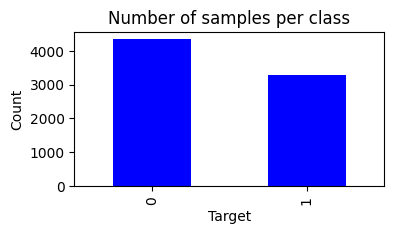

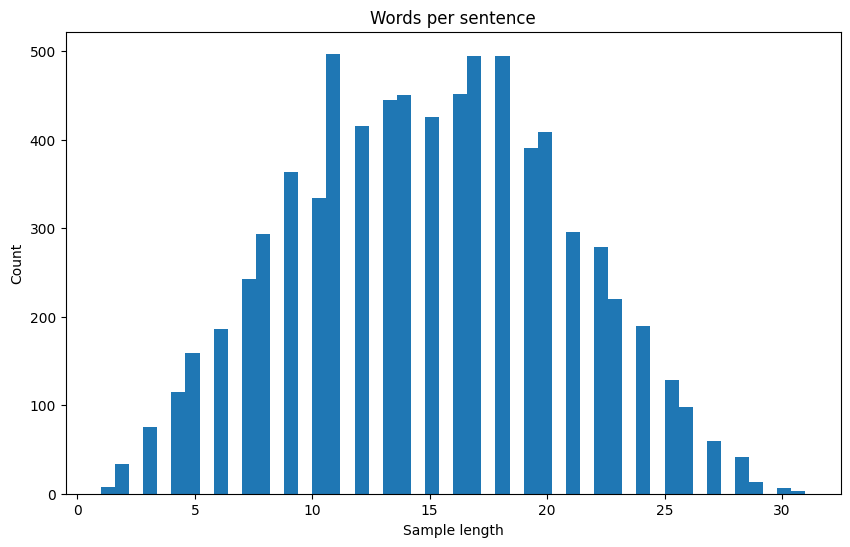

In [10]:
# Check number of samples per class
train['target'].value_counts().plot(kind='bar', figsize=(4,2), title='Number of samples per class', color='blue')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

# Sample length distribution
train['text'].apply(lambda x: len(x.split())).plot(kind='hist', title='Words per sentence', bins=50, figsize=(10,6))
plt.xlabel('Sample length')
plt.ylabel('Count')
plt.show()

In [11]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to clean tweets
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Remove mentions and hashtags (keeping the words if useful)
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove special characters, punctuation, and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization (converting words to their base form)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join words back into a single string
    return " ".join(tokens)

# Function to clean a dataset column
def preprocess_column(df, column):
    df[column] = df[column].astype(str).apply(clean_text)
    return df


In [12]:
# Clean the 'text' column
df = preprocess_column(train, 'text')

# Display cleaned data
print(df[['text']].head())

                                                text
0                    deed reason may allah forgive u
1              forest fire near la ronge sask canada
2  resident asked shelter place notified officer ...
3         people receive evacuation order california
4             got sent photo ruby smoke pours school


### Model Training

#### Model 1: Baseline model
I will use a simple model - TF-IDF + Logistic Regression as a baseline model. Following is what it does:
1. Convert the text to TF-IDF representation
2. Use Logistic Regression for classification into the two classes - label=0 and label=1

In [13]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 words
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8043
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



In [14]:
import pandas as pd
X_test_df = pd.DataFrame({'text': X_test, }) 
misclassified = X_test_df[((y_pred != y_test) & (y_test==1))]
pd.set_option('display.max_colwidth', None)  # Show full text

print(f"False Negative text")
print(misclassified['text'][:10])

False Negative text
2644                                                           new weapon cause unimaginable destruction
1765                       favorite lady came volunteer meeting hopefully joining youth collision excite
1817    ux fail emv people want insert remove quickly like gas pump stripe reader person told crashed po
3624                                                      month mark total fatality first half last year
5324                                              pandemonium aba woman delivers baby without face photo
6539                          miracle mankind survived year since one worst day history bet survive next
4518                   wait thought fecal hurricane scifi maybe turdnado ive forgeting shit storm lately
7253                                  reagan administration arranged israeli weapon sent guatemalan army
230                           people annihilated last night weather really philip thought would forecast
6292              today storm pas l

Deductions:
* The model is having an accuracy of 80.43%.
* Recall of 68% for label 1 shows model missed to classify a disaster tweet for 32% of times which is high. (almost 1 out of every 3 tweets)
* Based on F1 score we can see model is good at identifying label 0 category (ie non disaster tweet) and performs decent for label 1 (disaster category).

In [15]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=7000, min_df=1, max_df=0.95)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8037
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523



#### Method 2: Advanced model
In this methodology, I will use a more advanced approach to solve the issue. I will encode the sentences using word2vec model and then use LSTM for predicting the labels.

As majority of the sentences have ~30 words(as can be seen in the EDA graph) which is not that long, LSTM could still perform better because it will be able to remember the context from the entire text.

In [16]:
import numpy as np
import pandas as pd
import re
import nltk
import tensorflow as tf

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>
[nltk_data] Error loading punkt: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>


False

In [17]:
# Function to clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = ' '.join([word for word in word_tokenize(text) if word not in stopwords.words('english')])  # Remove stopwords
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Tokenize sentences
tokenized_sentences = [sentence.split() for sentence in df['clean_text']]


In [18]:
embedding_dim = 35
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

In [19]:
# Convert words to indices
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences
max_length = 500  # As found in EDA
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Convert labels
y = df['target'].values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [21]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │         424,095 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 424,095 (1.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 424,095 (1.62 MB)

In [22]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - accuracy: 0.5694 - loss: 0.6931
Test Accuracy: 0.5739


The above shows that our complex model did worse when compared to our Baseline model. Even the baseline model was able to have 80% accuracy.

My hypothesis is the word2Vec didn't learn good representations of the words. I will use pretrained vectors from Glove.

In [23]:
import numpy as np

# Define the file path to the GloVe embeddings file
glove_file_path = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt'

# Load GloVe embeddings into a dictionary
embedding_index = {}
embedding_dim = 100  # For 100-dimensional GloVe vectors

with open(glove_file_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coef = np.array(values[1:], dtype='float32')
        embedding_index[word] = coef

# Checking some loaded vectors
print(f"Vector for 'king': {embedding_index.get('king')[:5]}")
print(f"Vector for 'queen': {embedding_index.get('queen')[:5]}")


Vector for 'king': [-0.32307 -0.87616  0.21977  0.25268  0.22976]
Vector for 'queen': [-0.50045 -0.70826  0.55388  0.673    0.22486]


In [24]:
# Tokenize and pad the sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])  # Fit the tokenizer on your text data

# Convert text data to sequences of integers
sequences = tokenizer.texts_to_sequences(df['clean_text'])
X = pad_sequences(sequences, maxlen=35, padding='post')

# Labels (assuming it's binary classification)
y = df['target'].values  # Adjust the column name as per your dataset

print (X[:5])
print (X.shape)

[[3697  436   67 2397 3698    6    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [ 110    1  142  484 5352 5353 1179    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [1476 1348 1798  437 5354  306  164 1798  437  345  917    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  11 3699  164  345   38    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [  27 1030  115 5355  178 5356   92    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]
(7613, 35)


In [25]:
# Prepare the embedding matrix (map words in the tokenizer to GloVe vectors)
vocab_size = len(tokenizer.word_index) + 1  # Size of the vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Map words to their GloVe vectors
for word, i in tokenizer.word_index.items():
    if word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Build the model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=40, trainable=False),
    LSTM(64),  # LSTM layer
    Dropout(0.2),  # Another dropout layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       1,211,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,211,700 (4.62 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,211,700 (4.62 MB)

In [27]:
# Split the data into training and testing sets (if not done already)
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath="best_model_gLove_LSTM.keras",  # File to save the model
    monitor="val_accuracy",  # Track validation accuracy (or use "val_loss")
    save_best_only=True,  # Save only if the model improves
    mode="max",  # "max" for accuracy, "min" for loss
    verbose=1
)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, callbacks=[checkpoint_callback])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6806 - loss: 0.5936
Epoch 1: val_accuracy improved from -inf to 0.79383, saving model to best_model_gLove_LSTM.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6816 - loss: 0.5926 - val_accuracy: 0.7938 - val_loss: 0.4802
Epoch 2/20
190/191 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8011 - loss: 0.4641
Epoch 2: val_accuracy improved from 0.79383 to 0.79777, saving model to best_model_gLove_LSTM.keras
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8010 - loss: 0.4641 - val_accuracy: 0.7978 - val_loss: 0.4637
Epoch 3/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8012 - loss: 0.4562
Epoch 3: val_accuracy did not improve from 0.79777
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8012 - loss: 0.4560 - val_accuracy: 0.7958 - val_loss: 0.4613
Epoch 4/20
189/191 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8027 - loss: 0.4478
Epoch 4: val_accuracy improved from 0.79777 to 0.8

In [28]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot the training & validation accuracy and loss
    plt.figure(figsize=(12, 6))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()


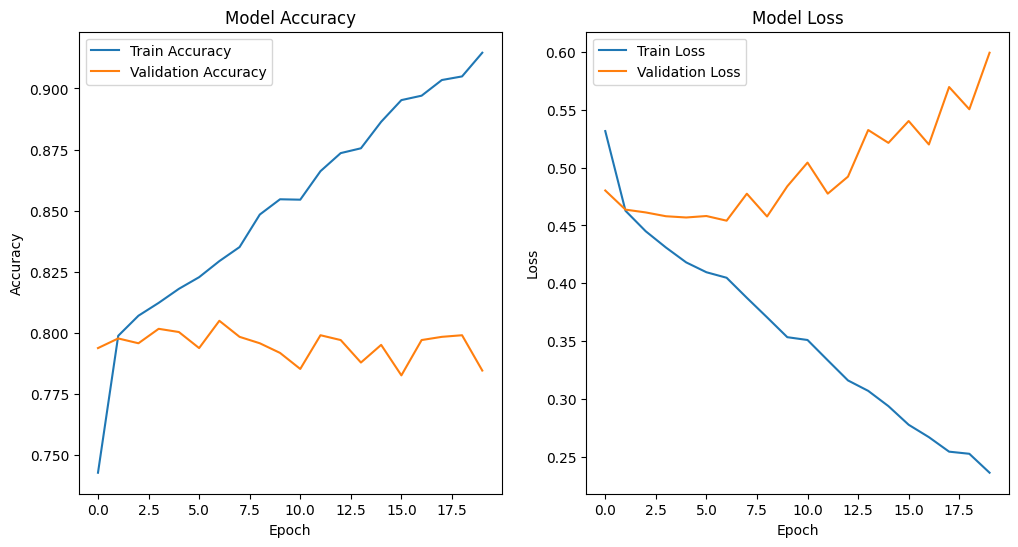

In [29]:
plot_history(history)

In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [31]:
from tensorflow.keras.models import load_model
best_model = load_model("best_model_gLove_LSTM.keras")

In [35]:
# Use the same tokenizer from training (DO NOT re-fit on test data)
df_test = preprocess_column(test, 'text')
df_test['clean_text'] = df_test['text'].apply(clean_text)
sequences = tokenizer.texts_to_sequences(df_test['clean_text'])  
X_test = pad_sequences(sequences, maxlen=35, padding='post')  

# Make predictions
predictions = best_model.predict(X_test)
y_pred = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

# Save to CSV
submission = pd.DataFrame({"id": test['id'], "target": y_pred.flatten()})
submission.to_csv("sample_submission.csv", index=False)

print("Predictions saved to sample_submission.csv ✅")


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Predictions saved to sample_submission.csv ✅


In [36]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=7000, min_df=1, max_df=0.95)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


Accuracy: 0.8037
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       874
           1       0.83      0.68      0.75       649

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.81      0.80      0.80      1523

